Loaded SpaCy pipeline.
Loading data from file: ./All-valid-data.spacy
Loaded 45 samples including 2598 entities.
Identified 2 classes: O, SKILL
Computed target vector!
Computing prediction vector...


100%|██████████| 45/45 [00:10<00:00,  4.47it/s]


<class 'numpy.ndarray'>
[[37203   589]
 [  661  2602]]
Generated confusion matrix!
Plotted confusion matrix!
Saving rendered image to: C:\Users\tom\projects\skill-skeleton\notebooks\pipelines\NER\spacy\7-evaluate-model/confusion.png
Saving confusion matrix data to: C:\Users\tom\projects\skill-skeleton\notebooks\pipelines\NER\spacy\7-evaluate-model/confusion.csv
Finished!


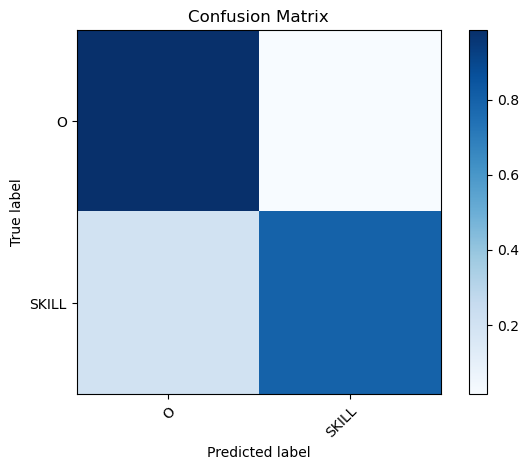

In [1]:
import warnings
import spacy
from spacy.scorer import Scorer
from spacy.tokens import DocBin
from spacy.training import Example
from spacy import displacy
import srsly
import typer
from pathlib import Path
import numpy
import os
import pandas as pd
from matplotlib import pyplot
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from spacy.training import offsets_to_biluo_tags

#######################################################################################################################

def _spacy_eval_list(nlp, data):   
    scorer = Scorer()    
    examples = []
    
    for text, annots in data:
        predicted=nlp(text)
        
        displacy.render(predicted, style="ent", jupyter=True)
        
        example=Example.from_dict(predicted, annots)
        examples.append(example)

    return Scorer.score_spans(examples, "ents")
    #return scorer.score(examples)

def _spacy_eval_binformat(nlp, data):
   
    scorer = Scorer()    
    examples = []    
       
    for element in data:        
        
        predicted=nlp(element['text'])
        example=Example.from_dict(predicted, {"entities": element['entities']})
        examples.append(example)

    return scorer.score(examples)

#######################################################################################################################

def _load_data_from_list(data):
   
    samples, entities_count = [], 0
    for text, ents in data:   
              
        sample = {
            "text": text,
            "entities": []
        }
        if len(ents['entities']) > 0:
            entities = [(item[0], item[1], item[2]) for item in ents['entities']]
            sample["entities"] = entities
            entities_count += len(entities)
        else:
            warnings.warn("Sample without entities!")
        samples.append(sample)
    return samples, entities_count


def _load_data(file_path: str, nlp):
    doc_bin = DocBin().from_disk(file_path)
    samples, entities_count = [], 0
    for doc in doc_bin.get_docs(nlp.vocab):
        sample = {
            "text": doc.text,
            "entities": []
        }
        if len(doc.ents) > 0:
            entities = [(e.start_char, e.end_char, e.label_) for e in doc.ents]
            sample["entities"] = entities
            entities_count += len(entities)
        else:
            warnings.warn("Sample without entities!")
        samples.append(sample)
    return samples, entities_count


def _get_cleaned_label(label: str):
    if "-" in label:
        return label.split("-")[1]
    else:
        return label


def _create_total_target_vector(nlp, samples):
    target_vector = []
    for sample in samples:
        doc = nlp.make_doc(sample["text"])
        ents = sample["entities"]
        bilou_ents = offsets_to_biluo_tags(doc, ents)
        vec = [_get_cleaned_label(label) for label in bilou_ents]
        target_vector.extend(vec)
    return target_vector


def _get_all_ner_predictions(nlp, text):
    doc = nlp(text)
    entities = [(e.start_char, e.end_char, e.label_) for e in doc.ents]
    bilou_entities = offsets_to_biluo_tags(doc, entities)
    return bilou_entities


def _create_prediction_vector(nlp, text):
    return [_get_cleaned_label(prediction) for prediction in _get_all_ner_predictions(nlp, text)]


def _create_total_prediction_vector(nlp, samples):
    prediction_vector = []
    for i in tqdm(range(len(samples))):
        sample = samples[i]
        prediction_vector.extend(_create_prediction_vector(nlp, sample["text"]))
    return prediction_vector


def _plot_confusion_matrix(cm, classes, normalize=False, text=True, cmap=pyplot.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    title = "Confusion Matrix"

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]

    fig, ax = pyplot.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=numpy.arange(cm.shape[1]),
           yticks=numpy.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    pyplot.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    if text:
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax, pyplot

def _generate_confusion_matrix(model_path,data_path,output_dir):
    spacy.prefer_gpu()
    nlp = spacy.load(model_path)
    print(f"Loaded SpaCy pipeline.")
    
    if type(data_path) == str:
        print(f"Loading data from file: {data_path}")    
        samples, entities_count = _load_data(data_path,nlp)
    else:
        print(f"Loading data from list.")    
        samples, entities_count = _load_data_from_list(data_path)
    

    print(f"Loaded {len(samples)} samples including {entities_count} entities.")
    classes = sorted(set(_create_total_target_vector(nlp, samples)))
    print(f"Identified {len(classes)} classes: {', '.join(classes)}")
    y_true = _create_total_target_vector(nlp, samples)
    print("Computed target vector!")
    print("Computing prediction vector...")
    y_pred = _create_total_prediction_vector(nlp, samples)
    matrix = confusion_matrix(y_true, y_pred, labels=classes)
    
    print(type(matrix))
    print(matrix)
    
    print("Generated confusion matrix!")
    cm_df = pd.DataFrame(matrix, columns=classes)
    cm_df.insert(0, "TARGETS", classes)
    ax, plot = _plot_confusion_matrix(matrix, classes, normalize=True, text=False)
    print("Plotted confusion matrix!")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    print(f"Saving rendered image to: {output_dir}/confusion.png")
    
    if os.path.isfile(f"{output_dir}/confusion.png"):
        os.remove(f"{output_dir}/confusion.png") 
    
    pyplot.savefig(f"{output_dir}/confusion.png")
    print(f"Saving confusion matrix data to: {output_dir}/confusion.csv")
    cm_df.to_csv(f"{output_dir}/confusion.csv")
    print("Finished!")

#######################################################################################################################

output_dir = "C:\\Users\\tom\projects\\skill-skeleton\\notebooks\\pipelines\\NER\\spacy\\7-evaluate-model"

data_path = "./All-valid-data.spacy"
#data_path= [[ "Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much. They were the last people you'd expect to be involved in anything strange or mysterious, because they just didn't hold with such nonsense.", { "entities": [ [ 0, 20, "PERSON" ] ] } ],[ "Elvis is a known person.", { "entities": [ [ 0, 5, "PERSON" ] ] } ]]

model_path= "C:/Users/tom/projects/skill-skeleton/models/NER/model-best-C_PT_E_HP"

_generate_confusion_matrix(model_path,data_path,output_dir)


#samples, entities_count = _load_data("./traindata.spacy",nlp)
#result2 = _spacy_eval_binformat(nlp, samples)
#result2
 
#scores = Scorer.score_spans(examples, "ents")
#print(scores["ents_f"])